### Environment Setup


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install rasterio
!pip install segmentation_models_pytorch
!pip install pytorch-lightning
!pip install albumentations

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import rasterio
import random

import torch
import albumentations
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

In [ ]:
%cd '/content/gdrive/MyDrive/Floodwater Detection'

In [ ]:
DATA_PATH = Path.cwd() / "training_data"
FEATURE_PATH = DATA_PATH / "train_features"
LABEL_PATH = DATA_PATH / "train_labels"

In [ ]:
train_metadata = pd.read_csv(
    DATA_PATH / "flood-training-metadata.csv", parse_dates=["scene_start"]
)

### Visualizing Rasters

In [ ]:
# Helper functions for visualizing Sentinel-1 images
def scale_img(matrix):
    """
    Returns a scaled (H, W, D) image that is visually inspectable.
    Image is linearly scaled between min_ and max_value, by channel.

    Args:
        matrix (np.array): (H, W, D) image to be scaled

    Returns:
        np.array: Image (H, W, 3) ready for visualization
    """
    # Set min/max values
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    # Reshape matrix
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)

    # Scale by min/max
    matrix = (matrix - min_values[None, :]) / (
        max_values[None, :] - min_values[None, :]
    )
    matrix = np.reshape(matrix, [w, h, d])

    # Limit values to 0/1 interval
    return matrix.clip(0, 1)


def create_false_color_composite(path_vv, path_vh):
    """
    Returns a S1 false color composite for visualization.

    Args:
        path_vv (str): path to the VV band
        path_vh (str): path to the VH band

    Returns:
        np.array: image (H, W, 3) ready for visualization
    """
    # Read VV/VH bands
    with rasterio.open(path_vv) as vv:
        vv_img = vv.read(1)
    with rasterio.open(path_vh) as vh:
        vh_img = vh.read(1)

    # Stack arrays along the last dimension
    s1_img = np.stack((vv_img, vh_img), axis=-1)

    # Create false color composite
    img = np.zeros((512, 512, 3), dtype=np.float32)
    img[:, :, :2] = s1_img.copy()
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]

    return scale_img(img)


def display_random_chip(random_state):
    """
    Plots a 3-channel representation of VV/VH polarizations as a single chip (image 1).
    Overlays a chip's corresponding water label (image 2).

    Args:
        random_state (int): random seed used to select a chip

    Returns:
        plot.show(): chip and labels plotted with pyplot
    """
    f, ax = plt.subplots(1, 2, figsize=(9, 9))

    # Select a random chip from train_metadata
    random_chip = train_metadata.chip_id.sample(random_state=random_state).values[0]

    # Extract paths to image files
    vv_path = FEATURE_PATH / f"{random_chip}_vv.tif"
    vh_path = FEATURE_PATH / f"{random_chip}_vh.tif"
    label_path = LABEL_PATH / f"{random_chip}.tif"

    # Create false color composite
    s1_img = create_false_color_composite(vv_path, vh_path)

    # Visualize features
    ax[0].imshow(s1_img)
    ax[0].set_title("S1 Chip", fontsize=14)

    # Load water mask
    with rasterio.open(label_path) as lp:
        lp_img = lp.read(1)

    # Mask missing data and 0s for visualization
    label = np.ma.masked_where((lp_img == 0) | (lp_img == 255), lp_img)

    # Visualize water label
    ax[1].imshow(s1_img)
    ax[1].imshow(label, cmap="cool", alpha=1)
    ax[1].set_title("S1 Chip with Water Label", fontsize=14)

    plt.tight_layout(pad=5)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide


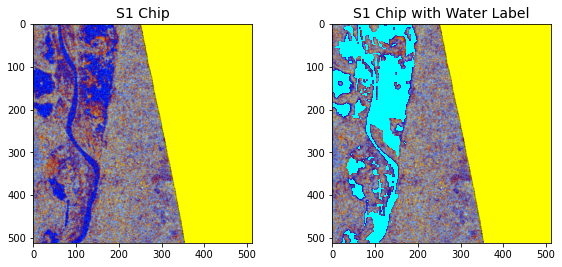

In [ ]:
display_random_chip(90)

## Data Preprocessing

In [ ]:
random.seed(9)  # set a seed for reproducibility 

# Sample 3 random floods for validation set
flood_ids = train_metadata.flood_id.unique().tolist()
val_flood_ids = random.sample(flood_ids, 3)
val_flood_ids

['pxs', 'qxb', 'jja']

In [ ]:
# Calculate mean and std for each feature layer for chips in the training set

names = ['vh', 'vv', 'change', 'extent', 'occurrence', 'recurrence', 'seasonality', 'transitions', 'nasadem']
mean_std_dict = {}

for n in names:
  ims = []
  print('.............. Layer: {} ..................'.format(n))
  for j in flood_ids:
    if j not in val_flood_ids:
      layer = FEATURE_PATH.glob(f"{j}*{n}.tif")
      for i in layer:
        ims.append(rasterio.open(i).read(1))
  temp_dict = {}
  temp_dict['mean'] = np.mean(np.array(ims))
  temp_dict['std'] = np.std(np.array(ims))
  mean_std_dict[n] = temp_dict
  print('mean: {}'.format(np.mean(np.array(ims))))
  print('std: {}'.format(np.std(np.array(ims))))

In [ ]:
# Generating training and validation sets
val_df = train_metadata[train_metadata.flood_id.isin(val_flood_ids)].copy()
train_df = train_metadata[~train_metadata.flood_id.isin(val_flood_ids)].copy()

In [ ]:
print(mean_std_dict)

{'vh': {'mean': -18.140356, 'std': 5.914469}, 'vv': {'mean': -11.392056, 'std': 5.300249}, 'change': {'mean': 238.83527686947681, 'std': 43.86870988973307}, 'extent': {'mean': 4.991384110164121, 'std': 34.93638759508637}, 'occurrence': {'mean': 10.059134884610202, 'std': 40.00489946421588}, 'recurrence': {'mean': 13.328970705876586, 'std': 42.52525809518595}, 'seasonality': {'mean': 5.555491077443941, 'std': 34.98626345520255}, 'transitions': {'mean': 0.4804414426042734, 'std': 1.7366941362920225}, 'nasadem': {'mean': 159.74797268643405, 'std': 109.37120172173906}}


In [ ]:
class FloodDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(self, metadata, feature_dir, label_dir=None, transforms=None):
        self.chip_ids = metadata.chip_id.tolist()
        self.feature_dir = feature_dir
        self.label_dir = label_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.chip_ids)

    def std(self, arr, mean, std):
        return (arr - mean) / std

    def __getitem__(self, idx):
        # Loads a 2-channel image from a chip_id
        chip_id = self.chip_ids[idx]
        vv_path = self.feature_dir / f"{chip_id}_vv.tif"
        vh_path = self.feature_dir / f"{chip_id}_vh.tif"
        with rasterio.open(vv_path) as vv:
            vv_img = vv.read(1)
        with rasterio.open(vh_path) as vh:
            vh_img = vh.read(1)
        with rasterio.open(self.feature_dir / f'{chip_id}_nasadem.tif') as vh:
            elev = vh.read(1)
        with rasterio.open(self.feature_dir / f'{chip_id}_jrc-gsw-extent.tif') as vh:
            extent = vh.read(1)
        with rasterio.open(self.feature_dir / f'{chip_id}_jrc-gsw-occurrence.tif') as vh:
            occur = vh.read(1)
        with rasterio.open(self.feature_dir / f'{chip_id}_jrc-gsw-recurrence.tif') as vh:
            recurr = vh.read(1)
        with rasterio.open(self.feature_dir / f'{chip_id}_jrc-gsw-seasonality.tif') as vh:
            seas = vh.read(1)
        with rasterio.open(self.feature_dir / f'{chip_id}_jrc-gsw-transitions.tif') as vh:
            trans = vh.read(1)
        with rasterio.open(self.feature_dir / f'{chip_id}_jrc-gsw-change.tif') as vh:
            change = vh.read(1)
        
        # Standardizing feature layers
        vv_img = self.std(vv_img, mean_std_dict['vv']['mean'], mean_std_dict['vv']['std'])
        vh_img = self.std(vh_img, mean_std_dict['vh']['mean'], mean_std_dict['vh']['std'])
        elev   = self.std(elev, mean_std_dict['nasadem']['mean'], mean_std_dict['nasadem']['std'])
        extent = self.std(extent, mean_std_dict['extent']['mean'], mean_std_dict['extent']['std'])
        occur  = self.std(occur, mean_std_dict['occurrence']['mean'], mean_std_dict['occurrence']['std'])
        recurr = self.std(recurr, mean_std_dict['recurrence']['mean'], mean_std_dict['recurrence']['std'])
        seas   = self.std(seas, mean_std_dict['seasonality']['mean'], mean_std_dict['seasonality']['std'])
        trans  = self.std(trans, mean_std_dict['transitions']['mean'], mean_std_dict['transitions']['std'])
        change = self.std(change, mean_std_dict['change']['mean'], mean_std_dict['change']['std'])
        
        x_arr = np.stack([
                            vv_img,
                            vh_img,
                            elev,
                            extent,
                            occur, 
                            recurr, 
                            seas, 
                            trans, 
                            change, 
                          ], axis=-1
                        ).astype(np.float32)

        # Apply data augmentations, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])

        # Prepare sample dictionary
        sample = {"chip_id": chip_id, "chip": x_arr}

        # Load label if available - training only
        if self.label_dir is not None:
            label_path = self.label_dir / f"{chip_id}.tif"
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1)
            # Apply same data augmentations to label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            sample["label"] = y_arr

        return sample

In [ ]:
# These transformations will be passed to our model class 
training_transformations = albumentations.Compose(
    [
        albumentations.RandomCrop(256, 256),
        albumentations.RandomRotate90(),
        albumentations.HorizontalFlip(),
        albumentations.VerticalFlip(),
    ]
)

In [ ]:
class XEDiceLoss(torch.nn.Module):
    """
    Computes (0.5 * CrossEntropyLoss) + (0.5 * DiceLoss).
    """

    def __init__(self):
        super().__init__()
        self.xe = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, pred, true):
        valid_pixel_mask = true.ne(255)  # valid pixel mask

        # Cross-entropy loss
        temp_true = torch.where(~valid_pixel_mask, 0, true)  # cast 255 to 0 temporarily
        xe_loss = self.xe(pred, temp_true)
        xe_loss = xe_loss.masked_select(valid_pixel_mask).mean()

        # Dice loss
        pred = torch.softmax(pred, dim=1)[:, 1]
        pred = pred.masked_select(valid_pixel_mask)
        true = true.masked_select(valid_pixel_mask)
        dice_loss = 1 - (2.0 * torch.sum(pred * true)) / (torch.sum(pred + true) + 1e-7)

        return (0.5 * xe_loss) + (0.5 * dice_loss)

In [ ]:
def intersection_and_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum(), union.sum()

In [ ]:
class FloodModel(pl.LightningModule):
    def __init__(self, train_metadata, val_metadata, hparams):
        super(FloodModel, self).__init__()
        self.hparams.update(hparams)
        self.feature_dir = self.hparams.get("feature_dir")
        self.label_dir = self.hparams.get("label_dir")
        self.train_chip_ids = self.hparams.get("train_chip_ids")
        self.val_chip_ids = self.hparams.get("val_chip_ids")
        self.transform = training_transformations
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.max_epochs = self.hparams.get("max_epochs", 1000)
        self.min_epochs = self.hparams.get("min_epochs", 6)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.fast_dev_run = self.hparams.get("fast_dev_run", False)
        self.val_sanity_checks = self.hparams.get("val_sanity_checks", 0)
        self.gpu = self.hparams.get("gpu", False)
        
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model_outputs")
        self.output_path.mkdir(exist_ok=True)
        self.log_path = Path.cwd() / hparams.get("log_path", "tensorboard_logs")
        self.log_path.mkdir(exist_ok=True)
        
        # Instantiate training and val datasets
        self.train_dataset = self._build_df(train_metadata, group="train")
        self.val_dataset = self._build_df(val_metadata, group="val")

        # Instantiate model and trainer params
        self.model = self._prepare_model()
        self.trainer_params = self._get_trainer_params()

        # Track validation IOU globally (reset each epoch)
        self.intersection = 0
        self.union = 0


    ## Required LightningModule methods ##


    def forward(self, image):
        # Forward pass
        return self.model(image)

    def training_step(self, batch, batch_idx):
        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Calculate training loss
        criterion = XEDiceLoss()
        xe_dice_loss = criterion(preds, y)

        # Log batch xe_dice_loss
        self.log(
            "xe_dice_loss", xe_dice_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size
        )
        return xe_dice_loss

    def validation_step(self, batch, batch_idx):
        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1

        # Calculate validation IOU (global)
        intersection, union = intersection_and_union(preds, y)
        self.intersection += intersection
        self.union += union

        # Log batch IOU
        batch_iou = intersection / union
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=self.batch_size
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=0,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        # Define optimizer
        optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.learning_rate
        )
        # Define scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="max", factor=0.5, patience=self.patience
        )
        scheduler = {
            "scheduler": scheduler, "interval": "epoch", "monitor": "iou_epoch",
        }  # logged value to monitor
        return [optimizer], [scheduler]

    def validation_epoch_end(self, outputs):
        # Reset metrics before next epoch
        self.intersection = 0
        self.union = 0

    
    ## Convenience Methods ##


    def _build_df(self, metadata, group):
        # Instantiate datasets
        if group == "train":
            df = FloodDataset(
                    metadata=metadata,
                    feature_dir=self.feature_dir,
                    label_dir=self.label_dir,
                    transforms=self.transform
            )
        elif group == "val":
            df = FloodDataset(
                    metadata=metadata,
                    feature_dir=self.feature_dir,
                    label_dir=self.label_dir,
                    transforms=None
            )
        return df
    
    def _prepare_model(self):
        # Instantiate U-Net model
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=9,
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()
        return unet_model

    def _get_trainer_params(self):
        # Define callback behavior
        checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=self.output_path,
            monitor="iou_epoch",
            mode="max",
            verbose=True,
        )
        # Define early stopping behavior
        early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
            monitor="iou_epoch",
            patience=(self.patience * 3),
            mode="max",
            verbose=True,
        )
        # Specify where TensorBoard logs will be saved
        logger = pl.loggers.TensorBoardLogger(self.log_path, name="benchmark-model")
        trainer_params = {
            "callbacks": [checkpoint_callback, early_stop_callback],
            "max_epochs": self.max_epochs,
            "min_epochs": self.min_epochs,
            "default_root_dir": self.output_path,
            "logger": logger,
            "gpus": None if not self.gpu else 1,
            "fast_dev_run": self.fast_dev_run,
            "num_sanity_val_steps": self.val_sanity_checks,
        }
        return trainer_params

    def fit(self):
        # Set up and fit Trainer object
        self.trainer = pl.Trainer(**self.trainer_params)
        self.trainer.fit(self)

In [ ]:
hparams = {
    # Required hparams
    "feature_dir": FEATURE_PATH,
    "label_dir": LABEL_PATH,
    # Optional hparams
    "backbone": "resnet34",
    "weights": "imagenet",
    "lr": 1e-3,
    "min_epochs": 1,
    "max_epochs": 5,
    "patience": 4,
    "batch_size": 32,
    "num_workers": 2,
    "val_sanity_checks": 0,
    "fast_dev_run": False,
    "output_path": "model_outputs",
    "log_path": "tensorboard_logs",
    "gpu": torch.cuda.is_available(),
}

In [ ]:
flood_model = FloodModel(train_metadata=train_df, val_metadata=val_df, hparams=hparams)
flood_model.fit()